In [1]:
%load_ext autoreload
%autoreload 2

from darts.datasets import ETTh1Dataset
import numpy as np
import pandas as pd
import torch
import random
import csv
import datetime
import os
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader, Dataset
from torch.autograd import Variable
from torchmetrics.regression import MeanAbsoluteError, MeanSquaredError
from sklearn.preprocessing import StandardScaler

import optuna
from optuna.trial import TrialState
from optuna.visualization import plot_optimization_history, plot_param_importances, plot_timeline

import models.models_original
import models.models_3d_atomics
from vasopressor.preprocess_helpers import *
from models.helper import *
from models.param_initializations import *
from models.optimization_strategy import greedy_forward_selection

device = torch.device('cuda') if torch.cuda.is_available else torch.device('cpu')
device

device(type='cuda')

In [2]:
class LinearModel(nn.Module):
    """
    Just one Linear layer
    """
    def __init__(self, configs):
        super(LinearModel, self).__init__()
        self.seq_len = configs["seq_len"]
        self.pred_len = configs["pred_len"]
        
        # Use this line if you want to visualize the weights
        # self.Linear.weight = nn.Parameter((1/self.seq_len)*torch.ones([self.pred_len,self.seq_len]))
        self.channels = configs["enc_in"]
        self.individual = configs["individual"]
        if self.individual:
            self.Linear = nn.ModuleList()
            for i in range(self.channels):
                self.Linear.append(nn.Linear(self.seq_len,self.pred_len))
        else:
            self.Linear = nn.Linear(self.seq_len, self.pred_len)

    def forward(self, x):
        # x: [Batch, Input length, Channel]
        if self.individual:
            output = torch.zeros([x.size(0),self.pred_len,x.size(2)],dtype=x.dtype).to(x.device)
            for i in range(self.channels):
                output[:,:,i] = self.Linear[i](x[:,:,i])
            x = output
        else:
            x = self.Linear(x.permute(0,2,1)).permute(0,2,1)
        return x # [Batch, Output length, Channel]

2016-07-01 00:00:00
2018-06-26 19:00:00


<Axes: xlabel='date'>

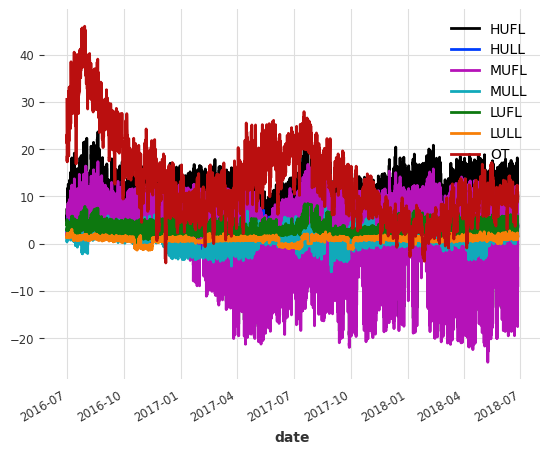

In [3]:
series = ETTh1Dataset().load()

print(series.start_time())
print(series.end_time())

series.plot()

In [4]:
class TimeSeriesDataset(Dataset):
    def __init__(self, data, targets, T, window_stride=1, pred_len=1):
        self.data = data
        self.targets = targets
        assert targets.size(0) == data.size(0)
        self.T = T # time window
        self.window_stride = window_stride
        self.pred_len = pred_len
        self.N, self.V = data.shape

    def __len__(self):
        return len(range(0, self.N - self.T - self.pred_len + 1, self.window_stride))

    def __getitem__(self, idx):
        start = idx * self.window_stride
        end = start + self.T

        X = self.data[start:end]
        # y = self.targets[end:end + self.pred_len].squeeze(-1)
        y = self.data[end:end + self.pred_len]
        return X, y


In [5]:
def preprocess_data(series, seq_len, window_stride=1, pred_len=1, batch_size = 1024):
    scaler = StandardScaler(with_std=False)
    
    train, test = series.split_before(0.6)
    val, test = test.split_before(0.5)
    
    print("Train/Val/Test", len(train), len(val), len(test))
    
    train_og = train.pd_dataframe()
    train = scaler.fit_transform(train_og)
    train = pd.DataFrame(train, columns=train_og.columns)
    X_train = train
    y_train = train[["OT"]]
    X_train = torch.tensor(X_train.to_numpy(), dtype=torch.float32)
    y_train = torch.tensor(y_train.to_numpy(), dtype=torch.float32)
    
    # indicators = torch.isfinite(X_train)
    # X_train = torch.cat([X_train, indicators], axis=1)
    
    train_dataset = TimeSeriesDataset(X_train, y_train, seq_len, window_stride, pred_len)
    train_loader = DataLoader(train_dataset, batch_size = batch_size, shuffle=False, num_workers=4, pin_memory=True)

    val_og = val.pd_dataframe()
    val = scaler.transform(val_og)
    val = pd.DataFrame(val, columns=val_og.columns)
    X_val = val
    y_val = val[["OT"]]
    X_val = torch.tensor(X_val.to_numpy(), dtype=torch.float32)
    y_val = torch.tensor(y_val.to_numpy(), dtype=torch.float32)
    
    # indicators = torch.isfinite(X_val)
    # X_val = torch.cat([X_val, indicators], axis=1)
    
    val_dataset = TimeSeriesDataset(X_val, y_val, seq_len, window_stride, pred_len)
    val_loader = DataLoader(val_dataset, batch_size = batch_size, shuffle=False, num_workers=4, pin_memory=True)

    test_og = test.pd_dataframe()
    test = scaler.transform(test_og)
    test = pd.DataFrame(test, columns=test_og.columns)
    X_test = test
    y_test = test[["OT"]]
    X_test = torch.tensor(X_test.to_numpy(), dtype=torch.float32)
    y_test = torch.tensor(y_test.to_numpy(), dtype=torch.float32)
    
    # indicators = torch.isfinite(X_test)
    # X_test = torch.cat([X_test, indicators], axis=1)
    
    test_dataset = TimeSeriesDataset(X_test, y_test, seq_len, window_stride, pred_len)
    test_loader = DataLoader(test_dataset, batch_size = batch_size, shuffle=False, num_workers=4, pin_memory=True)
    
    return train_loader, val_loader, test_loader, scaler


In [6]:
def plot_losses(train_losses, val_losses):
    plt.plot(train_losses, color="black", label="Train")
    plt.plot(val_losses, color="green", label="Val")
    plt.legend()
    plt.show()


In [7]:
batch_size = 32
learning_rate = 0.005
epochs = 1000
seq_len = 336
pred_len = 96

config = {
    'seq_len': seq_len,        # Sequence length
    'pred_len': pred_len,        # Prediction length
    'enc_in': 7,          # Number of input channels
    'individual': False   # Use individual linear layers or a single linear layer
}

In [8]:
experiment_folder = f"/workdir/optimal-summaries-public/_models/etth1/linear-L{seq_len}-T{pred_len}/"
model_path = experiment_folder + "linear.pt"
random_seed = 1

if not os.path.exists(experiment_folder):
    os.makedirs(experiment_folder)

In [9]:
train_loader, val_loader, test_loader, scaler = preprocess_data(series, seq_len, pred_len=pred_len, batch_size=batch_size)

for X,y in train_loader:
    print(X.shape)
    print(y.shape)
    break

print("Batches", len(train_loader), len(val_loader), len(test_loader))

Train/Val/Test 10451 3484 3485
torch.Size([32, 96, 7])
torch.Size([32, 96, 7])
Batches 321 103 103


In [10]:
model = LinearModel(config).to(device)
model

LinearModel(
  (Linear): Linear(in_features=96, out_features=96, bias=True)
)

In [11]:
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)
loss_func = nn.MSELoss().to(device)

mae_metric = MeanAbsoluteError().to(device)
mse_metric = MeanSquaredError().to(device)

In [12]:

for epoch in range(epochs):
    model.train()
    train_loss = 0
    for X,y in train_loader:
        X,y = X.to(device), y.to(device)
        
        optimizer.zero_grad()
        
        out = model.forward(X)
                
        loss = loss_func(out, y)
        loss.backward()
        
        train_loss += loss * X.size(0)
                        
    train_loss = loss / len(train_loader.sampler)
    
    optimizer.step()
    
    model.eval()
    with torch.no_grad():
        val_loss = 0
        for X,y in val_loader:
            X,y = X.to(device), y.to(device)
            out = model.forward(X)
            print(X.shape, y.shape, out.shape)
            val_loss += loss_func(out, y) * X.size(0)
            
            mae = mae_metric(out, y).item()
            mse = mse_metric(out, y).item()
        mae = mae_metric.compute().item()
        mse = mse_metric.compute().item()
        mae_metric.reset()
        mse_metric.reset()

        val_loss = val_loss / len(val_loader.sampler)
        
    print(f"Train Loss {train_loss}, Val Loss {val_loss}")
    print(f"MAE = {mae}")
    print(f"MSE = {mse}")
    

torch.Size([32, 96, 7]) torch.Size([32, 96, 7]) torch.Size([32, 96, 7])


RuntimeError: view size is not compatible with input tensor's size and stride (at least one dimension spans across two contiguous subspaces). Use .reshape(...) instead.